# Áp dụng SoftMax vào bộ dữ liệu

In [68]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import sparse
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, classification_report,precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import time
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

Chuẩn bị dữ liệu

In [69]:
import os
BASE_DIR = os.path.dirname(
    os.path.dirname(
        os.path.dirname(
            os.path.abspath('notebook/preprocessing.ipynb'))))

# Sử dụng trên bộ dữ liệu 9 class và 4 class
# Do đầu ra của bộ dữ liệu có một số class quá ít nên ta tiến hành loại bỏ các hàng dữ liệu chứa các class thiểu số đó
df_4_class = pd.read_csv(os.path.join(BASE_DIR, 'data/processed_data_4_classes.csv'))
df_9_class = pd.read_csv(os.path.join(BASE_DIR, 'data/processed_data_9_classes.csv'))

df_pca_9_class = pd.read_csv(os.path.join(BASE_DIR, 'data/X_9_classes_PCA_6dims.csv'))
df_pca_4_class = pd.read_csv(os.path.join(BASE_DIR, 'data/X_4_classes_PCA_6dims.csv'))

df_lda_9_class = pd.read_csv(os.path.join(BASE_DIR, 'data/X_9_classes_LDA_2dims.csv'))
df_lda_4_class = pd.read_csv(os.path.join(BASE_DIR, 'data/X_4_classes_LDA_2dims.csv'))

In [70]:
df_9_class['Classification'].value_counts()

Classification
C3S1    696
C2S1    248
C4S1     87
C4S2     36
C3S2     12
C4S4      7
C3S3      6
C4S3      5
OG        4
Name: count, dtype: int64

In [71]:
df_4_class['Classification'].value_counts()

Classification
C3S1    696
C2S1    248
C4S1     87
C4S2     36
Name: count, dtype: int64

## Xây dựng mô hình

In [72]:
def convert_labels(y, C):
  """
  convert 1d label to a matrix label: each column of this
  matrix coresponding to 1 element in y. In i-th column of Y,
  only one non-zeros element located in the y[i]-th position,
  and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return

  [[1, 0, 0, 1],
  [0, 0, 1, 0],
  [0, 1, 0, 0]]
  """
  Y = sparse.coo_matrix((np.ones_like(y),
  (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
  return Y


def softmax_stable(Z):
  """
  Compute softmax values for each sets of scores in Z.
  each column of Z is a set of score.
  """
  e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
  A = e_Z / e_Z.sum(axis = 0)
  return A

def softmax(Z):
  """
  #Compute softmax values for each sets of scores in V.
  #each column of V is a set of score.
  """
  e_Z = np.exp(Z)
  A = e_Z / e_Z.sum(axis = 0)
  return A
def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 10000):
  W = [W_init]
  C = W_init.shape[1]
  Y = convert_labels(y, C)
  it = 0
  N = X.shape[1]
  d = X.shape[0]

  count = 0
  check_w_after = 20
  while count < max_count:
    # mix data
    mix_id = np.random.permutation(N)
    for i in mix_id:
      xi = X[:, i].reshape(d, 1)
      yi = Y[:, i].reshape(C, 1)
      ai = softmax_stable(np.dot(W[-1].T, xi))
      W_new = W[-1] + eta*xi.dot((yi - ai).T)
      count += 1
      # stopping criteria
      if count%check_w_after == 0:
        if np.linalg.norm(W_new - W[-check_w_after]) < tol:
          return W

      W.append(W_new)
  return W

# cost or loss function
def cost(X, Y, W):
  A = softmax_stable(W.T.dot(X))
  return -np.sum(Y*np.log(A))

# Predict that X belong to which class (1..C now indexed as 0..C-1 )
def pred(W, X):
  """
  predict output of each columns of X
  Class of each x_i is determined by location of max probability
  Note that class are indexed by [0, 1, 2, ...., C-1]
  """
  A = softmax_stable(W.T.dot(X))
  return np.argmax(A, axis = 0)

# W[-1] is the solution, W is all history of weights

Viết 1 hàm để đánh giá mô hình trên các kịch bản dữ liệu khác nhau

In [73]:
def test_softmax(df,test_size, eta = 0.05):
  target = 'Classification'
  x = df.drop(target, axis = 1)
  y = df[target]
  x = np.asarray(x)
  y = np.asarray(y)
  # Label encoder giá trị đầu ra y
  LB = LabelEncoder()
  y = LB.fit_transform(y)
  # chia tập train/test
  x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=test_size, random_state=14, stratify=y)
  # Chuẩn hóa dữ liệu về cùng 1 đơn vị đo
  sc = StandardScaler()
  x_train_normalized = sc.fit_transform(x_train)
  x_test_normalized = sc.transform(x_test)

  # Thêm cột 1 vào x_train, x_test
  x_train_normalized = np.concatenate((np.ones((x_train_normalized.shape[0],1)), x_train_normalized), axis = 1)
  x_test_normalized = np.concatenate((np.ones((x_test_normalized.shape[0],1)), x_test_normalized), axis = 1)

  # áp dụng mô hình vào x_train
  eta = 0.05
  d = x_train_normalized.shape[1]
  c = len(df['Classification'].unique())
  W_init = np.random.rand(d, c)
  W = softmax_regression(x_train_normalized.T, y_train, W_init, eta)
  y_pred = pred(W[-1], x_test_normalized.T)

  print(classification_report(y_test,y_pred))

  # In ra ma trận nhầm lẫn
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LB.classes_)
  disp.plot(cmap='Blues', xticks_rotation=45)
  plt.title("Confusion Matrix: Thực tế vs Dự đoán")
  plt.show()

### Kịch bản 1 (train/test = 8/2)

#### Áp dụng trên bộ dữ liệu gốc 9 class

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        50
           1       0.93      0.98      0.95       140
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         1
           4       0.75      0.83      0.79        18
           5       0.33      0.14      0.20         7
           6       0.00      0.00      0.00         1
           7       0.50      1.00      0.67         1
           8       0.00      0.00      0.00         1

    accuracy                           0.90       221
   macro avg       0.50      0.48      0.47       221
weighted avg       0.89      0.90      0.89       221



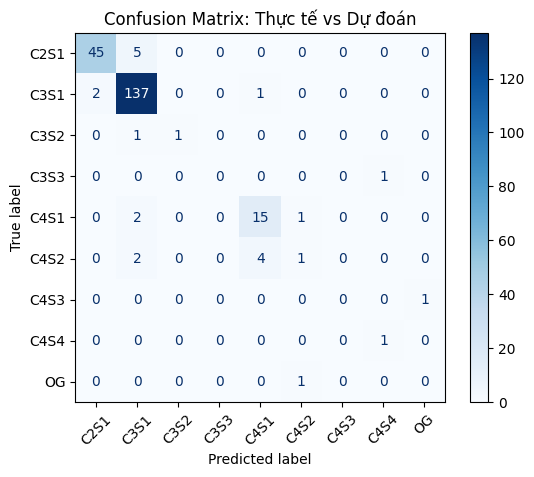

Thời gian chạy chương trình: 0.280803918838501s


In [74]:
start_time = time.time()
test_softmax(df_9_class,test_size=0.2)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 2 (Train/Test = 0.7/0.3)

#### Áp dụng trên bộ dữ liệu gốc 9 class

              precision    recall  f1-score   support

           0       0.96      0.88      0.92        75
           1       0.94      0.97      0.96       209
           2       0.38      0.75      0.50         4
           3       0.00      0.00      0.00         2
           4       0.62      0.81      0.70        26
           5       0.20      0.09      0.12        11
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1

    accuracy                           0.89       331
   macro avg       0.34      0.39      0.36       331
weighted avg       0.87      0.89      0.88       331



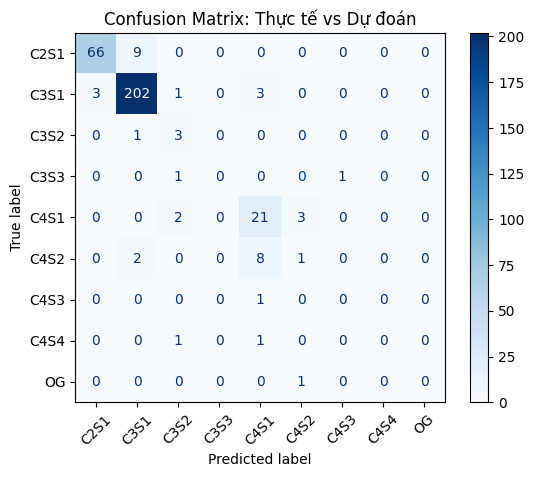

Thời gian chạy chương trình: 0.24807333946228027s


In [75]:
start_time = time.time()
test_softmax(df_9_class,test_size=0.3)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 3 (Train/Test = 0.6/0.4)

#### Áp dụng trên bộ dữ liệu gốc với 9 class

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        99
           1       0.94      0.97      0.96       279
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         2
           4       0.79      0.74      0.76        35
           5       0.57      0.57      0.57        14
           6       0.00      0.00      0.00         2
           7       0.40      0.67      0.50         3
           8       0.00      0.00      0.00         2

    accuracy                           0.91       441
   macro avg       0.52      0.50      0.50       441
weighted avg       0.90      0.91      0.91       441



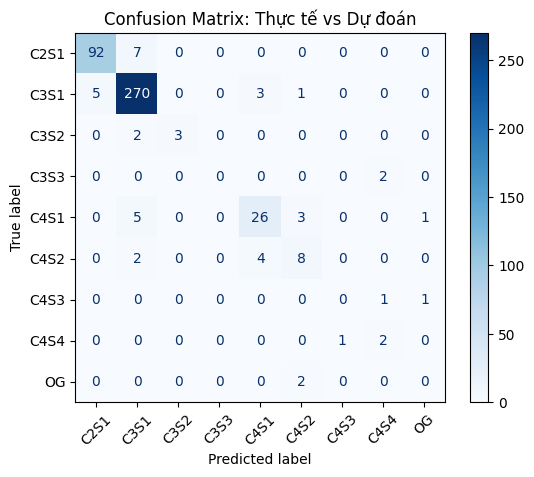

Thời gian chạy chương trình: 0.25382184982299805s


In [76]:
start_time = time.time()
test_softmax(df_9_class,test_size=0.4)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

Nhận xét:
- Nhìn chung mô hình dự đoán khá tốt các class đa số
- Các class thiểu số mô hình dự đoán chưa được tốt
- Do các class mất bằng dữ liệu khá nhiều nên ta sẽ sử dụng **marco avg f1 score** để đánh giá mô hình
- marco avg f1 score lần lượt của 3 kịch bản dữ liệu lần lượt là : **0.47, 0.36, 0.50**

### Kịch bản 1 (Train/Test = 0.8/0.2)

#### Áp dụng trên bộ dữ liệu gốc với 4 class

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        50
           1       0.99      0.94      0.97       140
           2       0.59      1.00      0.74        17
           3       0.00      0.00      0.00         7

    accuracy                           0.93       214
   macro avg       0.63      0.73      0.67       214
weighted avg       0.92      0.93      0.92       214



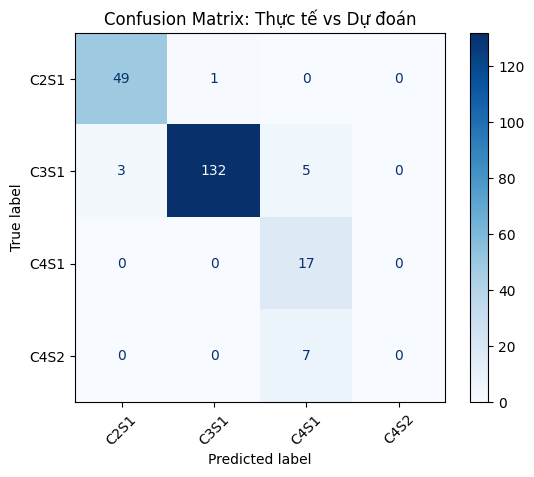

Thời gian chạy chương trình: 0.1795961856842041s


In [77]:
start_time = time.time()
test_softmax(df_4_class,test_size=0.2)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 2 (Train/Test = 0.7/0.3)

#### Áp dụng trên bộ dữ liệu gốc 4 class

              precision    recall  f1-score   support

           0       0.95      0.92      0.93        75
           1       0.95      0.97      0.96       209
           2       0.76      0.73      0.75        26
           3       0.40      0.36      0.38        11

    accuracy                           0.92       321
   macro avg       0.76      0.75      0.75       321
weighted avg       0.91      0.92      0.91       321



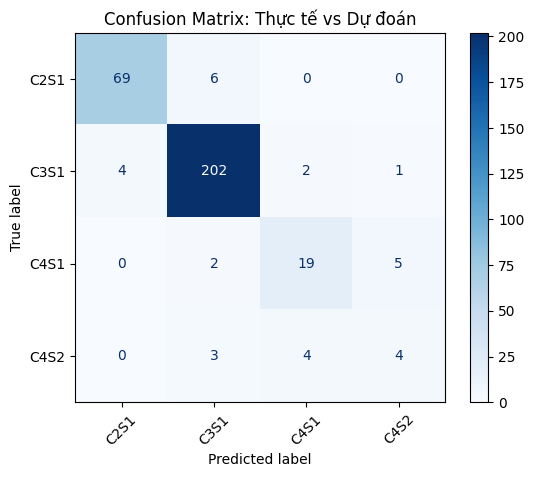

Thời gian chạy chương trình: 0.3032693862915039s


In [78]:
start_time = time.time()
test_softmax(df_4_class,test_size=0.3)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 3 (Train/Test = 0.6/0.4)

#### Áp dụng trên bộ dữ liệu gốc 4 class

              precision    recall  f1-score   support

           0       0.98      0.90      0.94        99
           1       0.94      0.98      0.96       279
           2       0.78      0.83      0.81        35
           3       0.38      0.21      0.27        14

    accuracy                           0.93       427
   macro avg       0.77      0.73      0.74       427
weighted avg       0.92      0.93      0.92       427



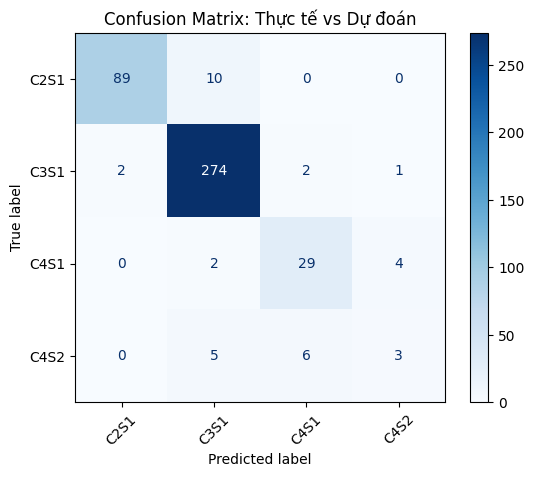

Thời gian chạy chương trình: 0.18070268630981445s


In [79]:
start_time = time.time()
test_softmax(df_4_class,test_size=0.4)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

Nhận xét:
- Nhìn chúng mô hình cũng đã tốt lên
- avg marco f1 score lần lượt của 3 kịch bản là : **0.67, 0.75, 0.74** đã tăng so với dữ liệu gốc 9 class

## PCA

### Kịch bản 1 (Train/Test = 0.8/0.2)

Áp dụng pca trên bộ dữ liệu vẫn gồm 9 class

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        50
           1       0.95      0.99      0.97       140
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.75      0.83      0.79        18
           5       0.50      0.29      0.36         7
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.92       221
   macro avg       0.46      0.45      0.45       221
weighted avg       0.90      0.92      0.91       221



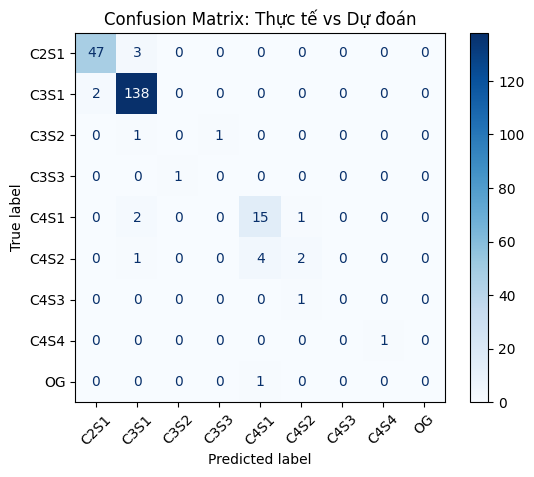

Thời gian chạy chương trình: 0.22717046737670898s


In [80]:
start_time = time.time()
test_softmax(df_pca_9_class,test_size=0.2)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 2 (Train/Test = 0.7/0.3)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        75
           1       0.92      0.99      0.96       209
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.79      0.88      0.84        26
           5       0.67      0.18      0.29        11
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         1

    accuracy                           0.91       331
   macro avg       0.48      0.44      0.45       331
weighted avg       0.89      0.91      0.90       331



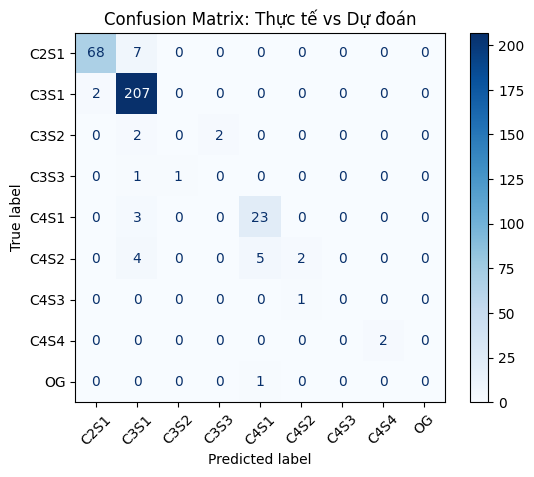

Thời gian chạy chương trình: 0.22782063484191895s


In [81]:
start_time = time.time()
test_softmax(df_pca_9_class,test_size=0.3)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 3 (Train/Test = 0.6/0.4)

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        99
           1       0.93      0.97      0.95       279
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         2
           4       0.68      0.80      0.74        35
           5       0.33      0.07      0.12        14
           6       0.00      0.00      0.00         2
           7       0.40      0.67      0.50         3
           8       0.00      0.00      0.00         2

    accuracy                           0.90       441
   macro avg       0.37      0.38      0.36       441
weighted avg       0.88      0.90      0.88       441



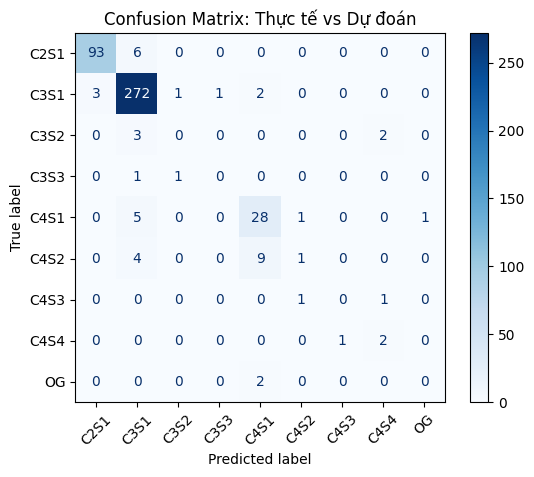

Thời gian chạy chương trình: 0.2326347827911377s


In [82]:
start_time = time.time()
test_softmax(df_pca_9_class,test_size=0.4)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

Nhận xét:
- Nhìn chung kết quả gần như tương đương với trường dữ liệu gốc

Áp dụng pca trên bộ dữ liệu gồm 4 class

### Kịch bản 1 (Train/Test = 0.8/0.2)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94        50
           1       0.95      0.99      0.97       140
           2       0.74      0.82      0.78        17
           3       0.50      0.14      0.22         7

    accuracy                           0.93       214
   macro avg       0.79      0.71      0.73       214
weighted avg       0.92      0.93      0.92       214



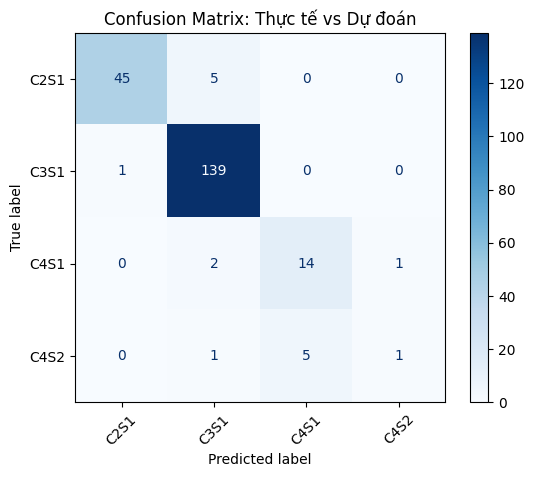

Thời gian chạy chương trình: 0.1904902458190918s


In [83]:
start_time = time.time()
test_softmax(df_pca_4_class,test_size=0.2)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 2 (Train / Test = 0.7/0.3)

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        75
           1       0.94      0.99      0.96       209
           2       0.71      0.77      0.74        26
           3       0.25      0.09      0.13        11

    accuracy                           0.92       321
   macro avg       0.72      0.68      0.69       321
weighted avg       0.90      0.92      0.91       321



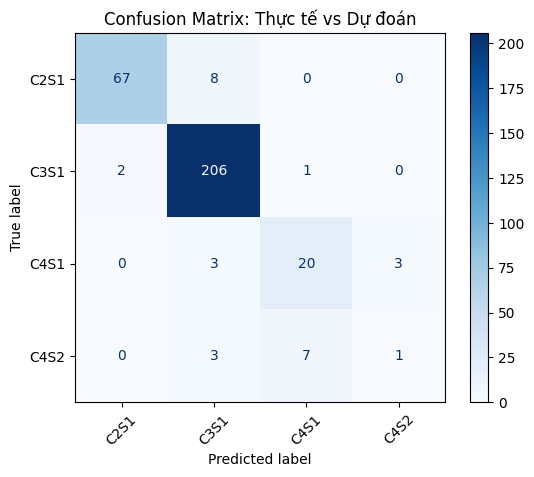

Thời gian chạy chương trình: 0.1930866241455078s


In [84]:
start_time = time.time()
test_softmax(df_pca_4_class,test_size=0.3)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 3 (Train/Test = 0.6/0.4)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        99
           1       0.95      0.98      0.97       279
           2       0.71      0.91      0.80        35
           3       0.00      0.00      0.00        14

    accuracy                           0.93       427
   macro avg       0.66      0.70      0.68       427
weighted avg       0.90      0.93      0.91       427



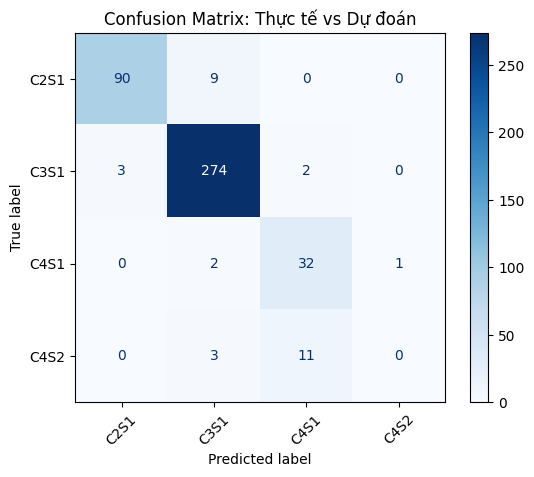

Thời gian chạy chương trình: 0.2090439796447754s


In [85]:
start_time = time.time()
test_softmax(df_pca_4_class,test_size=0.4)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

Nhận xét:
- Kết quả bị giảm một chút so với khi sử dụng dữ liệu gốc

## LDA

### Kịch bản 1 (Train/Test = 0.8/0.2)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        50
           1       0.94      0.98      0.96       140
           2       0.50      0.50      0.50         2
           3       0.00      0.00      0.00         1
           4       0.75      0.67      0.71        18
           5       0.40      0.29      0.33         7
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.91       221
   macro avg       0.50      0.49      0.49       221
weighted avg       0.89      0.91      0.90       221



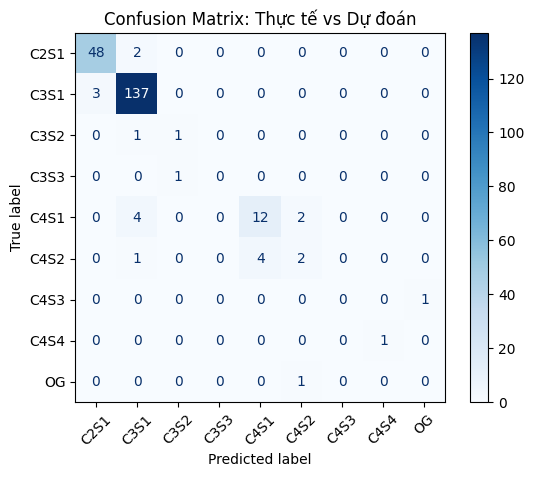

Thời gian chạy chương trình: 0.25187158584594727s


In [86]:
start_time = time.time()
test_softmax(df_lda_9_class,test_size=0.2)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 2 (Train/Test = 0.7/0.3)

              precision    recall  f1-score   support

           0       0.99      0.88      0.93        75
           1       0.92      0.99      0.95       209
           2       0.33      0.25      0.29         4
           3       0.00      0.00      0.00         2
           4       0.69      0.77      0.73        26
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         1
           7       0.50      1.00      0.67         2
           8       0.00      0.00      0.00         1

    accuracy                           0.89       331
   macro avg       0.38      0.43      0.40       331
weighted avg       0.86      0.89      0.88       331



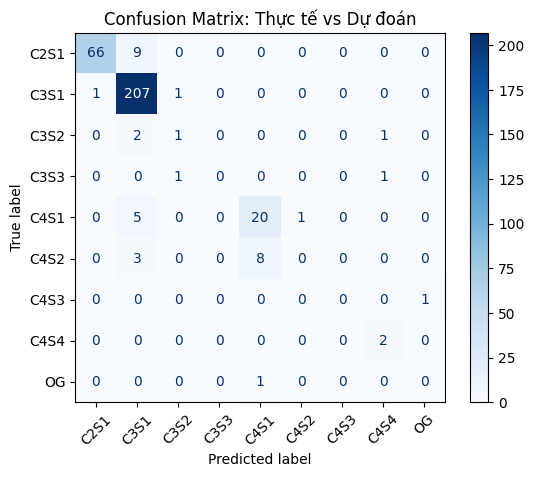

Thời gian chạy chương trình: 0.39565396308898926s


In [87]:
start_time = time.time()
test_softmax(df_lda_9_class,test_size=0.3)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 3 (Train/Test = 0.6/0.4)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94        99
           1       0.95      0.97      0.96       279
           2       0.29      0.40      0.33         5
           3       0.00      0.00      0.00         2
           4       0.86      0.71      0.78        35
           5       0.53      0.57      0.55        14
           6       0.00      0.00      0.00         2
           7       0.67      0.67      0.67         3
           8       0.00      0.00      0.00         2

    accuracy                           0.91       441
   macro avg       0.47      0.47      0.47       441
weighted avg       0.91      0.91      0.91       441



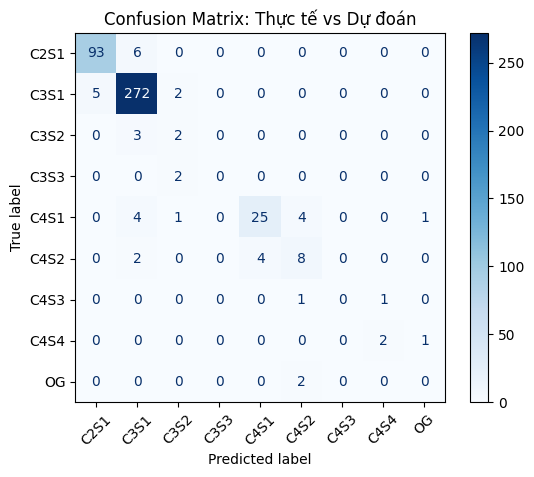

Thời gian chạy chương trình: 0.23816728591918945s


In [88]:
start_time = time.time()
test_softmax(df_lda_9_class,test_size=0.4)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

Nhận xét :
- Kết quả của mô hình khi sử dụng lda tốt hơn pca

### kịch bản 1 (Train / Test = 0.8/0.2)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        50
           1       0.94      0.96      0.95       140
           2       0.72      0.76      0.74        17
           3       1.00      0.57      0.73         7

    accuracy                           0.93       214
   macro avg       0.90      0.81      0.84       214
weighted avg       0.93      0.93      0.92       214



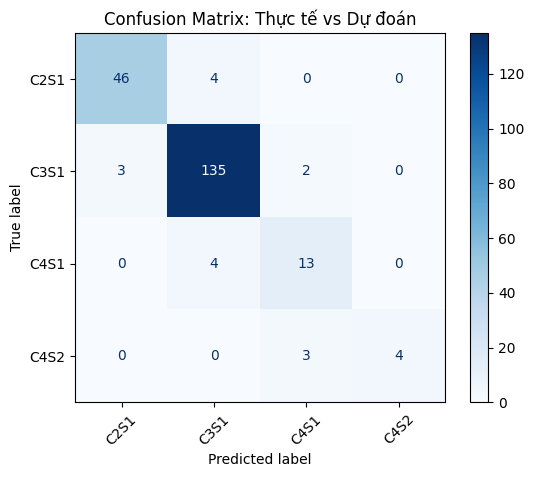

Thời gian chạy chương trình: 0.20113515853881836s


In [89]:
start_time = time.time()
test_softmax(df_lda_4_class,test_size=0.2)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 2 (Train / Test = 0.7/0.3)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        75
           1       0.95      0.96      0.95       209
           2       0.74      0.77      0.75        26
           3       0.80      0.36      0.50        11

    accuracy                           0.92       321
   macro avg       0.85      0.76      0.78       321
weighted avg       0.92      0.92      0.92       321



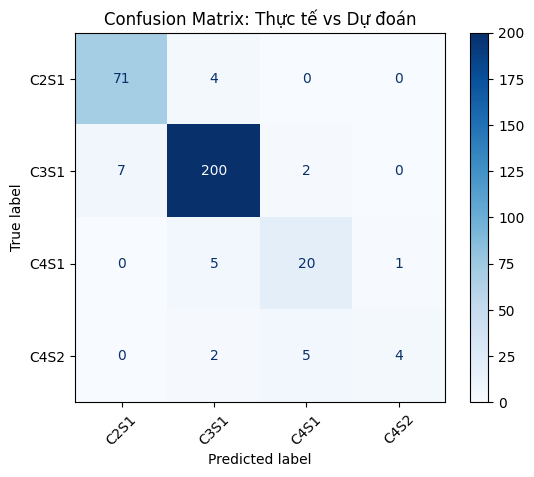

Thời gian chạy chương trình: 0.19478344917297363s


In [90]:
start_time = time.time()
test_softmax(df_lda_4_class,test_size=0.3)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

### Kịch bản 3: (Train / Test = 0.6/0.4)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        99
           1       0.93      0.99      0.96       279
           2       0.75      0.69      0.72        35
           3       0.67      0.29      0.40        14

    accuracy                           0.92       427
   macro avg       0.83      0.72      0.75       427
weighted avg       0.91      0.92      0.91       427



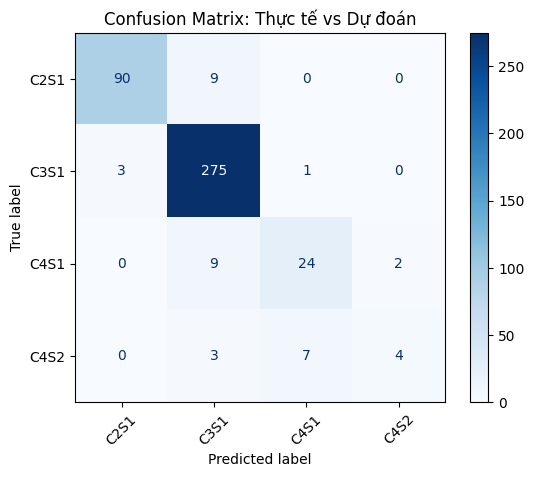

Thời gian chạy chương trình: 0.1853189468383789s


In [91]:
start_time = time.time()
test_softmax(df_lda_4_class,test_size=0.4)
end_time = time.time()
print(f'Thời gian chạy chương trình: {end_time - start_time}s')

Nhận xét :
- Kết quả của mô hình khi sử dụng lda đạt kết quả cao hơn pca


Nhận xét chung :
- Do dữ liệu bị mất cân bằng nên các kết quả của mô hình chưa được cao
- kết quả của mô hình khi sử dụng giảm chiều dữ liệu bằng lda sẽ cho kết quả cao hơn khi sử dụng giảm chiều dữ liệu bằng pca
- Ta sẽ thử oversample cho các class thiểu số


After: {'C2S1': 280, 'C3S1': 417, 'C4S2': 200, 'C4S1': 240}

Classification report
              precision    recall  f1-score   support

        C2S1       0.92      0.90      0.91        99
        C3S1       0.95      0.95      0.95       279
        C4S1       0.81      0.74      0.78        35
        C4S2       0.47      0.64      0.55        14

    accuracy                           0.91       427
   macro avg       0.79      0.81      0.79       427
weighted avg       0.92      0.91      0.91       427



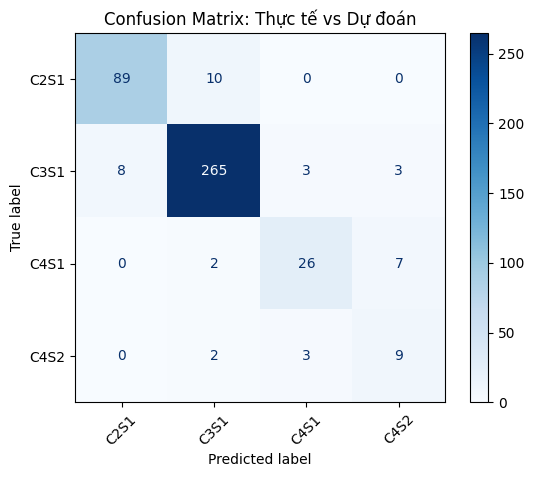

In [92]:
TARGETS_4 = {"C2S1": 280, "C4S1": 240, "C4S2": 200}

def train_softmax_with_ros_4class(df, test_size=0.2, eta=0.05):
    target_col = "Classification"

    # split
    X = df.drop(target_col, axis=1).to_numpy()
    y_str = df[target_col].to_numpy()

    LB = LabelEncoder()
    y = LB.fit_transform(y_str)  # 0..C-1

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=14, stratify=y
    )

    #build sampling strategy
    targets_encoded = {}
    for name, tgt in TARGETS_4.items():
        if name in LB.classes_:
            cid = int(LB.transform([name])[0])
            targets_encoded[cid] = tgt

    cnt_before = Counter(y_train)
    sampling_strategy = {cid: tgt for cid, tgt in targets_encoded.items()
                         if cid in cnt_before and tgt > cnt_before[cid]}

    # oversample TRAIN
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    cnt_after = Counter(y_train_res)
    print("After:", {LB.inverse_transform([k])[0]: v for k, v in cnt_after.items()})

    # standardize
    sc = StandardScaler()
    X_train_norm = sc.fit_transform(X_train_res)
    X_test_norm = sc.transform(X_test)

    #add bias column
    X_train_norm = np.concatenate([np.ones((X_train_norm.shape[0], 1)), X_train_norm], axis=1)
    X_test_norm  = np.concatenate([np.ones((X_test_norm.shape[0], 1)),  X_test_norm], axis=1)

    # train softmax regression
    d = X_train_norm.shape[1]
    C = len(LB.classes_)
    W_init = np.random.rand(d, C)

    W_hist = softmax_regression(X_train_norm.T, y_train_res, W_init, eta)
    y_pred = pred(W_hist[-1], X_test_norm.T)

    # evaluate
    print("\nClassification report")
    print(classification_report(
        y_test, y_pred,
        labels=list(range(C)),
        target_names=LB.classes_,
        zero_division=0
    ))

    cm = confusion_matrix(y_test, y_pred, labels=list(range(C)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LB.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix: Thực tế vs Dự đoán")
    plt.show()

    return W_hist[-1], sc, LB

# test
W_final, scaler, LB = train_softmax_with_ros_4class(df_4_class, test_size=0.4, eta=0.05)


=>> Sau khi oversample cho các class thiểu số thì độ chính xác của mô hình được cải thiện đáng kể